##### Grading Feedback
90%

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- Students may use toPandas() to print the head of data frames.
- Students are responsible for reading the usage comments and understanding how to properly use the get_training_filename() function.  Runtime errors which result from incorrect usage of get_training_filename() shall result in a  point reduction.  
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.  Heavy weight operations that convert data to pandas or spark (like collect()) will result in a point reduction.__

### Wine Analysis
I'm a big fan of wine and would love to use visualizations, machine learning, and inference to learn more about the characteristics of a good wine and predict good wines.  Unfortunately I'm too busy (and lazy) to do the analysis myself but I do have just under 60 trained data scientests at my disposal to do the research for me.  The data set contains the following columns:<br>

Input variables (based on physicochemical tests):

1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):
12. quality (score between 0 and 10)

In [1]:
# Do not delete or change this cell

# grading import statements
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
# Correct Usage Example (pass ONLY the full file name):
#   file_name_to_load = get_training_filename("sms_spam.csv") # correct - pass ONLY the full file name  
#   
# Incorrect Usage Example
#   file_name_to_load = get_training_filename("/sms_spam.csv") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("sms_spam.csv/") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("c:/users/will/data/sms_spam.csv") incorrect -pass ONLY the full file name
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as fn
import requests
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import length
from pyspark.sql import Row
from pyspark.ml.classification import GBTClassifier


spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Question 1 Data Wrangling: (10 pts)
Read the winequality-red.csv data set into a spark data frame named wine_df.  Use the get_training_filename function provided above to determine the appropriate file path based on the platform on which you are running. Check the resulting data frame for NA / NAN values and deal with these problems appropriately.  Note that the target variable has 10 classes.  Convert the 10 classes into 2 classes.  If the target variable is greater than or equal to 7, replace the label with a 1 indicating good wine.  If the target varible is less than 7, replace the label with a 0 indicating a lower quality wine.

In [3]:
# students shall create wine_df here

wine_df = spark.read.option("header","true").option("delimiter",",").option("inferSchema","true").csv(get_training_filename('winequality-red.csv'))

In [4]:
# grading cell: students shall print the head and shape of wine_df here

wine_df.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [5]:
print('Shape of wine_df is',(wine_df.count(),len(wine_df.columns)))

Shape of wine_df is (1599, 12)


In [6]:
# grading cell: students shall prove that there are no NA / NAN values in the wine_df here

from pyspark.sql.functions import isnan, isnull, when, count, col

wine_df.select([count(when(isnull(c), c)).alias(c) for c in wine_df.columns]).show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|            0|               0|          0|             0|        0|                  0|                   0|      0|  0|        0|      0|      0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+



In [7]:

from pyspark.sql.functions import isnan, isnull, when, count, col

wine_df.select([count(when(isnan(c), c)).alias(c) for c in wine_df.columns]).show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|            0|               0|          0|             0|        0|                  0|                   0|      0|  0|        0|      0|      0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+



In [8]:
wine_df = wine_df.withColumn('quality', when(wine_df.quality >= 7, 1)\
                  .when(wine_df.quality < 7, 0).otherwise(wine_df.quality).alias('quality'))

In [9]:
wine_df.select('quality').distinct().show()

+-------+
|quality|
+-------+
|      1|
|      0|
+-------+



In [10]:
wine_df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



##### Grading feedback cell

# Question 2 Visualizations (10 pts)
I am interested to know more about the data set.  Create one or more visualizations that summarize the data.  Write a short description that helps me understand the visualizations.  Tell me something interesting or surprising about the data.

In [11]:
# your code here

wine_df_pd = wine_df.toPandas()

In [12]:
wine_df_pd.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,0.135710
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.342587
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,0.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,0.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


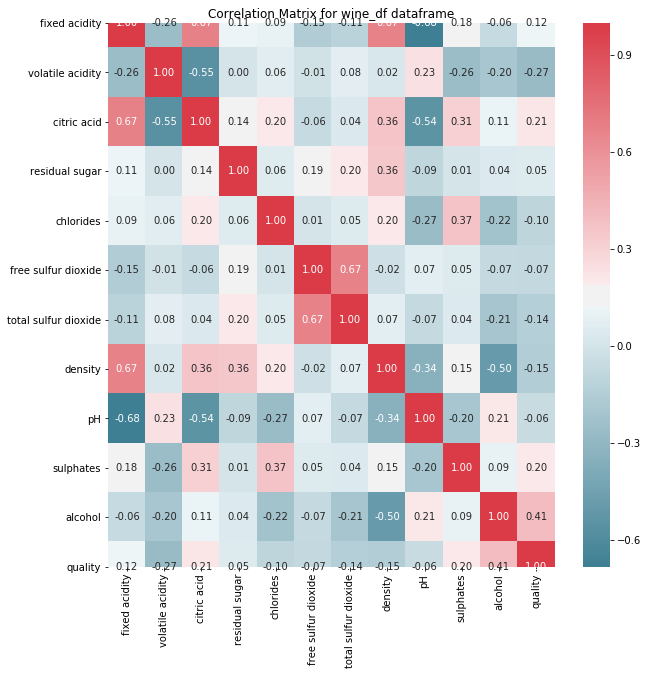

In [13]:
corr = wine_df_pd.corr()

fig, ax = plt.subplots(figsize=(10, 10))

colormap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")

plt.title("Correlation Matrix for wine_df dataframe")

plt.show()

Text(0.5, 1.05, 'Pairplot showing distribution of all variables along with their correlation')

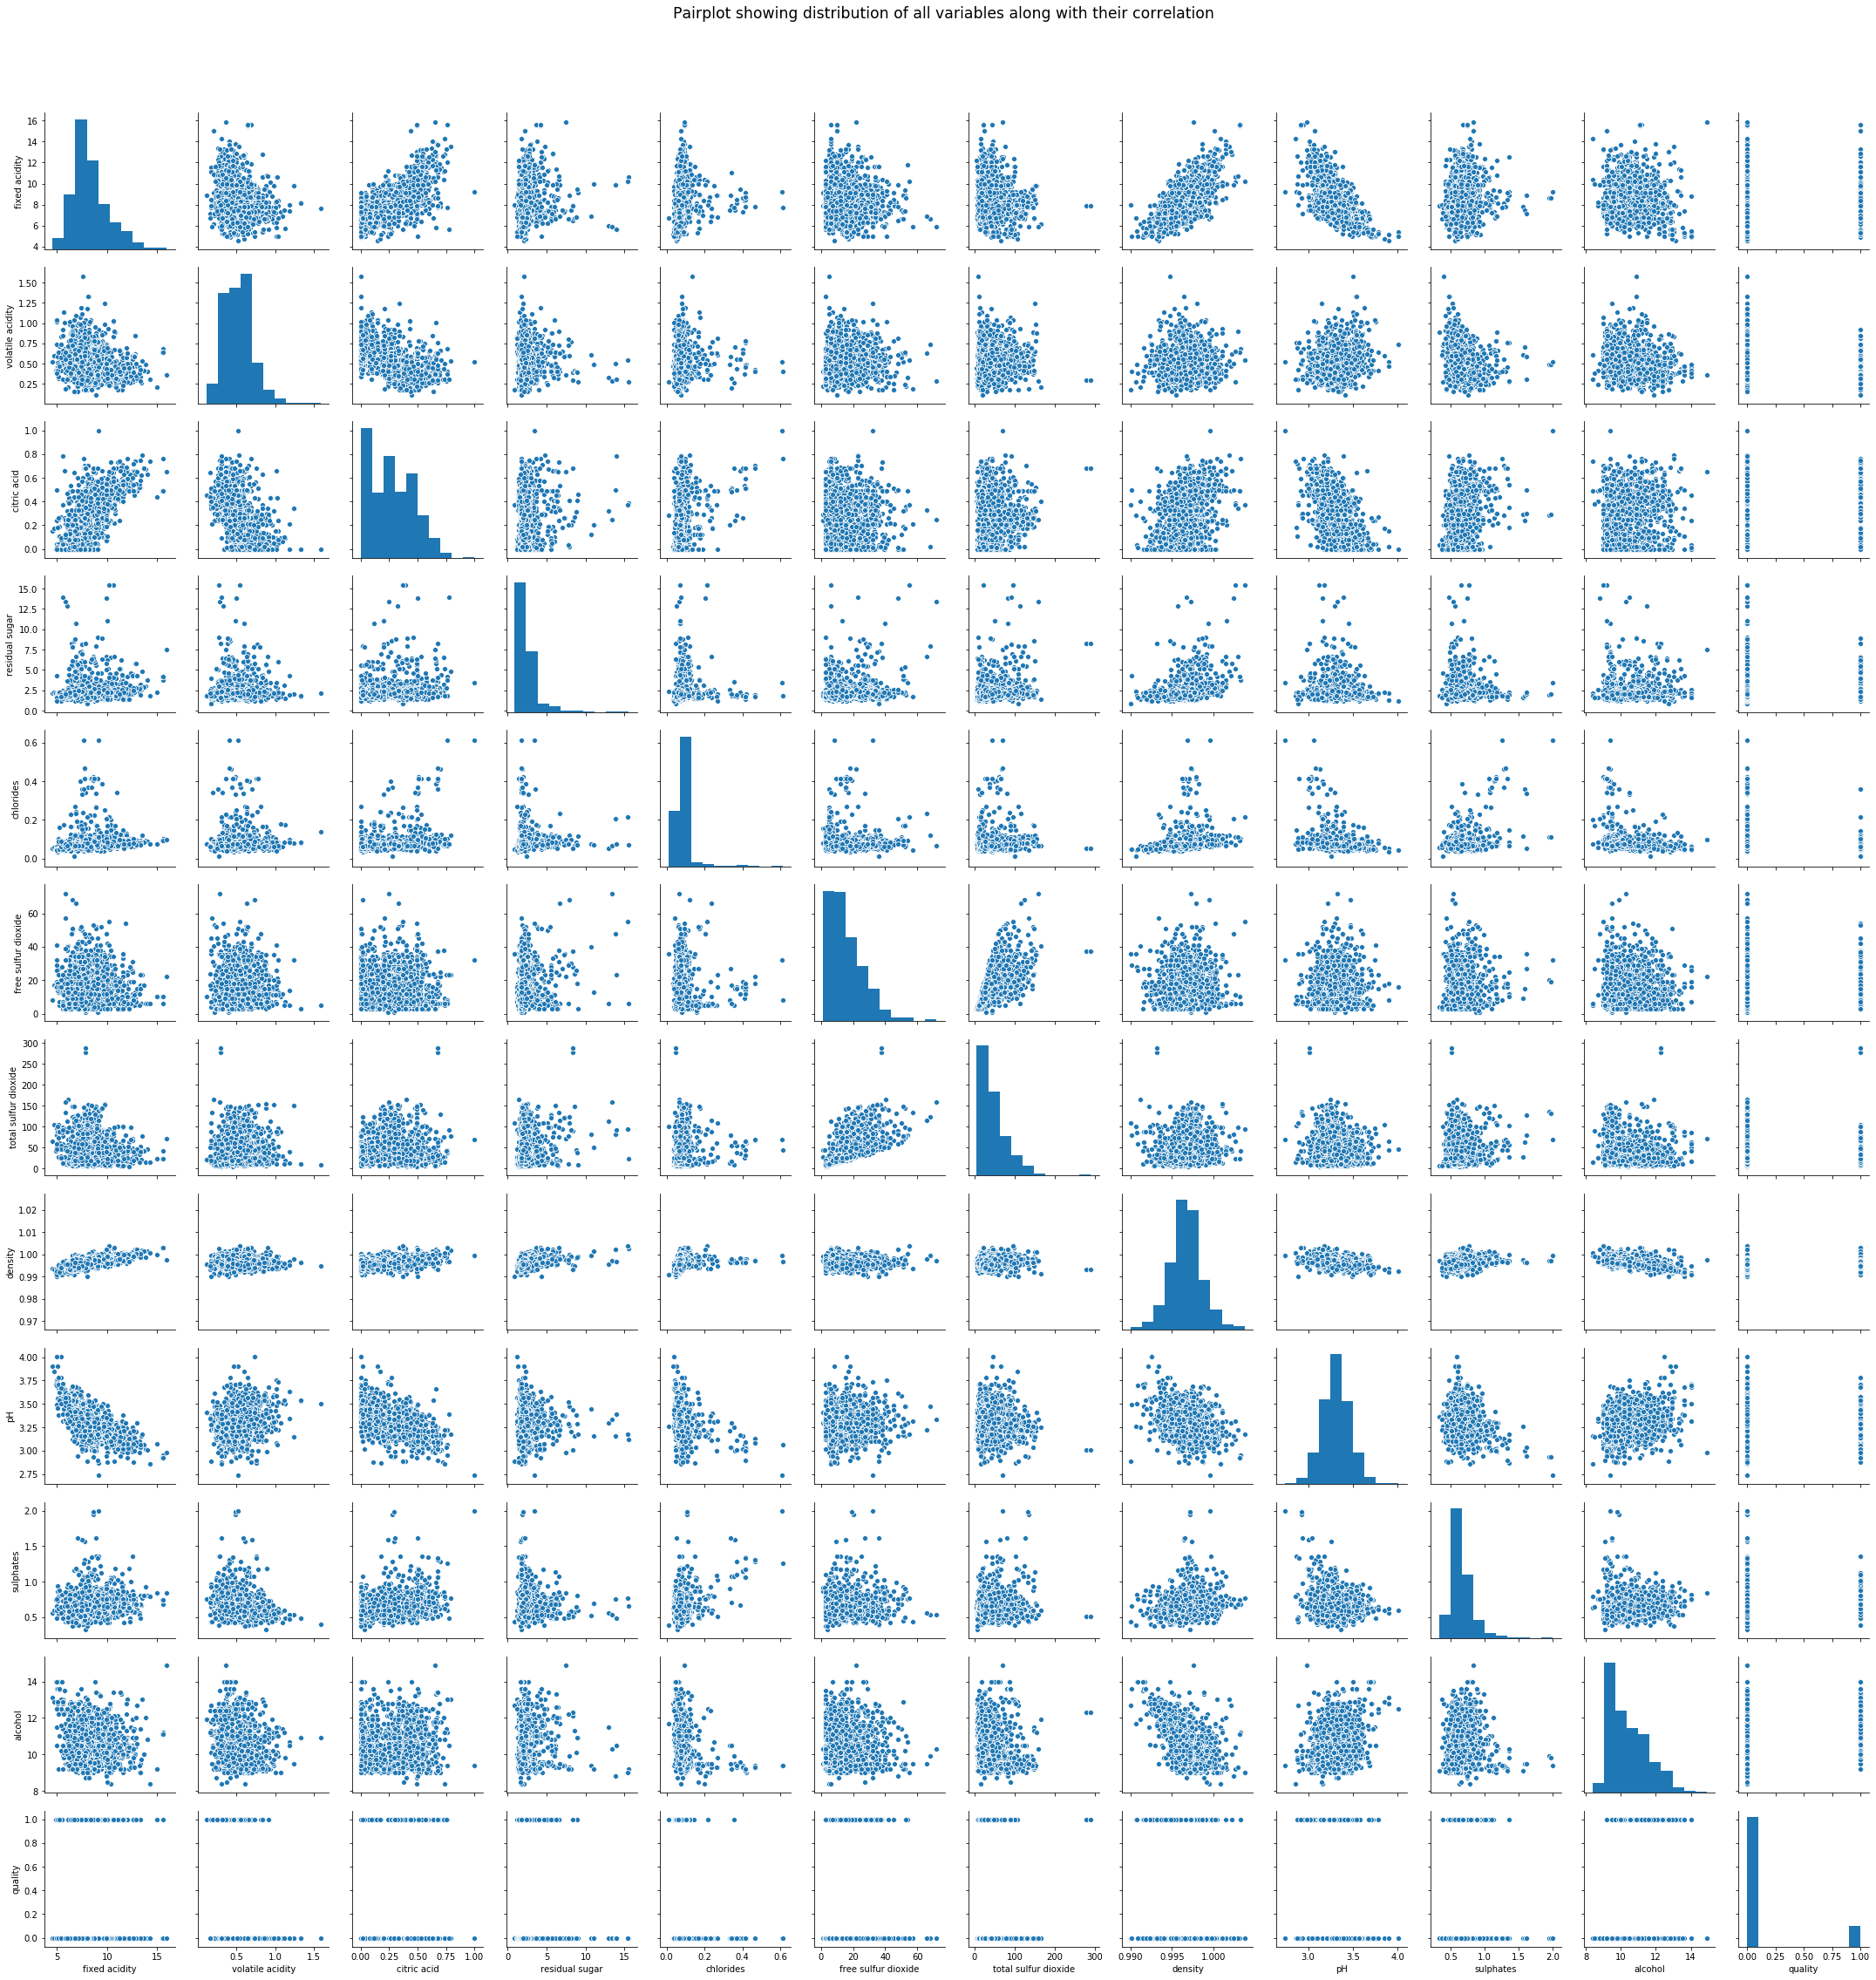

In [14]:
g= sns.pairplot(data=wine_df_pd)
g.fig.suptitle("Pairplot showing distribution of all variables along with their correlation", y=1.05,fontsize='xx-large')

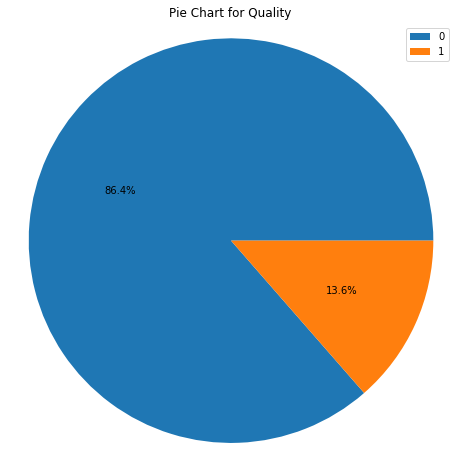

In [15]:
plt.figure(figsize = (8,8))
labels = wine_df_pd.quality.value_counts().index
plt.pie(wine_df_pd.quality.value_counts(), autopct='%1.1f%%')
plt.legend(labels, loc="best")
plt.axis('equal')
plt.title('Pie Chart for Quality')
plt.show()

Text(0.5, 0.98, ' Alcohol and Volatile acidity for each quality of wine')

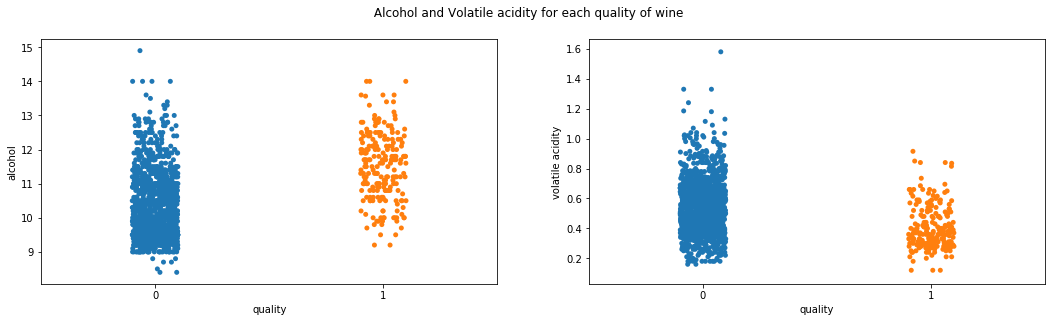

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18, 4.5)
sns.stripplot(data=wine_df_pd, x="quality", y="alcohol", jitter=True, ax=ax1)
sns.stripplot(data=wine_df_pd, x="quality", y="volatile acidity", jitter=True, ax=ax2)
fig.suptitle(" Alcohol and Volatile acidity for each quality of wine")

Your short description here:<br> The quality of wine has most poisitive correlation with alcohol. As the level of alcohol increases, quality of wine increases. The quality of wine is most negatively correlated with volatile acidity which means more the volatile acidity, the lower is the quality of the wine. Also, wine quality is positively correlated with amount of sulphates and citric acid present in the wine. The pairplot shows the distribution of each variable with itself and other variables. For a good quality wine, values of chlorides, residual sugar,sulphates should be low as seen from the pairplot of quality with other variables. The distribution of pH,density,fixed acidity and volatile acidity is almost normally distributed. Sulphates, alcohol, Residual Sugar, citric acid, free sulfur dioxide, total sulfur dioxide are right skewed with some outliers in total sulpur dioxide, chlorides, sulphates. The Pie chart shows that there are only 13.6% out of 100% good quality wines where the quality is greater than or equal to 7 meaning only around 14 wines are good out of 100 based on the scores of the quality. For a good quality wine the alcohol content is not less than 9% whereas for low quality wines the alcohol content is less than 9%. Also, for a good quality wine the volatile acidity value is almost always lower than 1 typically till 0.8 whereas for a low quality wine this value is above 1.

##### Grading Feedback
Excellent

# Random Forest

# Question 3: (10 pts)
Create a spark RandomForestClassifier using all default parameters.  Train the model and calculate the AUC using a BinaryClassificationEvaluator.

In [17]:
# Your code here

label_stringIdx = StringIndexer(inputCol="quality", outputCol="label")

training_df, testing_df = wine_df.randomSplit([0.6, 0.4],seed=123)

va = VectorAssembler().setInputCols([i for i in training_df.columns if i!='quality']).setOutputCol('features')

In [18]:
rf = RandomForestClassifier()

rf_pipe = Pipeline(stages=[label_stringIdx, va, rf])


In [19]:
rf_pipeline = rf_pipe.fit(training_df)

In [20]:
rf_pipeline.stages[-1].extractParamMap()

{Param(parent='RandomForestClassifier_75295a78f455', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_75295a78f455', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_75295a78f455', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_75295a78f455', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_75295a78f455', 

In [21]:
evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

In [22]:
predictions = (rf_pipeline.transform(testing_df))

In [23]:
predictions.select("label","prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [24]:

print("Testing Area Under ROC for RF model is " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Testing Area Under ROC for RF model is 0.8723864377309293


##### Grading Feedback

# Question 4: (10 pts)
Use spark RandomForestClassifier, ParamGridBuilder, and CrossValidator objects to perform a random forest grid search.  Use 3 fold cross validation and a BinaryClassificationEvaluator to evaluate the results.  The goal is to see if you can improve upon the AUC score produced by the default random forest model above.  You are free to choose any hyper parameters you want in your grid search.  You should be able to achieve an AUC score around / above 88%. 

In [25]:
# Your grid search code here

evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

rf_pipe = Pipeline(stages=[label_stringIdx,va, rf])

grid_rf = ParamGridBuilder().addGrid(rf.numTrees, [10, 30, 60]).addGrid(rf.maxDepth, [5, 10, 15]).addGrid(rf.impurity,["entropy", "gini"]).build()

cv1 = CrossValidator(estimator=rf_pipe,estimatorParamMaps=grid_rf, numFolds=3, evaluator=evaluator)

In [26]:
cvModel = cv1.fit(training_df)

In [27]:
best_predictions = cvModel.bestModel.transform(testing_df)

In [28]:
cvModel.bestModel.stages[-1].extractParamMap()

{Param(parent='RandomForestClassifier_75295a78f455', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_75295a78f455', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_75295a78f455', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_75295a78f455', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_75295a78f455', 

In [29]:
AUC_score_best_rf = np.max(cvModel.avgMetrics)

In [30]:
print("Area Under ROC for best RF model from Cross Validator model is " + str(AUC_score_best_rf))

Area Under ROC for best RF model from Cross Validator model is 0.8813503936505855


In [31]:
print("Testing Area Under ROC for best RF model is " + str(evaluator.evaluate(best_predictions, {evaluator.metricName: "areaUnderROC"})))

Testing Area Under ROC for best RF model is 0.9070202129971766


##### Grading Feedback

# Question 5 (10 pts)
Extract the cross validation AUC score and specific hyper parameters used from the grid search above.  Create a pandas dataframe where the first column is the grid parameter name and the 2nd colum is the grid parameter value.  Make the last row of the pandas data frame the resulting AUC score.  Print the pandas data frame.  Describe in words in the markdown cell below what specific parameters you used in your grid and what those parameters do in the model.  For example, if you specified impurity in your grid, describe what impurity does in the random forest.  Keep the descriptions brief and at a high level, I'm just trying to see if you understand the high level concept of what the tuning parameter does.

In [34]:
# Print the pandas data frame here

numTrees_rf = cvModel.bestModel.stages[-1]._java_obj.getNumTrees
maxdepth_rf = cvModel.bestModel.stages[-1]._java_obj.getMaxDepth()
impurity_rf = cvModel.bestModel.stages[-1]._java_obj.getImpurity()


In [35]:
df_grid_rf = pd.DataFrame({'Grid_Param_Name':['numTrees', 'maxDepth', 'impurity','AUC score'],
        'Grid_Param_Value':[numTrees_rf, maxdepth_rf, impurity_rf,AUC_score_best_rf]})

In [36]:
df_grid_rf

,Grid_Param_Name,Grid_Param_Value
0,numTrees,<py4j.java_gateway.JavaMember object at 0x0000...
1,maxDepth,10
2,impurity,entropy
3,AUC score,0.88135


Write your grid search parameter descriptions here: The parameters used in Grid Search were Number of Trees, Max Dpeth and Impurity. Number of trees for random forest algorithm are used to increase the accuracy by using bootstrap sampling technique to get data to be fed to each tree in the forest. As the number of trees increases the classification outcome is more accurate as we take majority vote from these trees leaf nodes to get final output to reduce high variance from just 1 tree and reduce overfitting. Also more number of trees help the algorithm learn better about data through more data using bootstrap sampling. Max Depth is the depth of the each tree in random forest meaning how deeper is the tree. Deeper the tree the more number of splits it has to make decision based on more conditions and thus capturing more information about the data. It takes into account more conditions increasing splits making it better to predict the outcome rather than only few splits based on limited conditions taken into account. Impurity is the measure based on which optimal condition for the decision to split the tree is taken. Gini Index is the measure of the impurity and entropy is popular for splitting the data based on maximum information gain at each split to reduce the randomness. As the randomness decreases we get more information gain for split of each tree node. Entropy giving the highest information gain would be used to split the node of the tree.


##### Grading Feedback
-5 runtime error fixed by grader. Incorrect value for numTrees in the pandas data frame.

# Question 6: 5 pts
Create a pandas dataframe containing 2 columns: `feature` and `importance`.  Load the feature column with the dataset feature names and the 2nd column with the feature importances as determined by the best model produced by the grid search above.  Sort the dataframe by `importance` in descending order. In the markdown cell, tell me the 3 features that are most important to predicting a good wine.

In [37]:
# Your code here

features = cvModel.bestModel.stages[1].getInputCols()
importance = cvModel.bestModel.stages[-1].featureImportances.values

feature_importance = dict(zip(features, importance))

In [38]:
feature_importance

{'fixed acidity': 0.07898700969152336,
 'volatile acidity': 0.11336731434152197,
 'citric acid': 0.08253022007485537,
 'residual sugar': 0.05117294160274477,
 'chlorides': 0.060684465832934846,
 'free sulfur dioxide': 0.054426034913224945,
 'total sulfur dioxide': 0.08613179520155793,
 'density': 0.08240670145366981,
 'pH': 0.05543611800994772,
 'sulphates': 0.14592558185952673,
 'alcohol': 0.18893181701849254}

In [39]:
feature_imp = pd.DataFrame({'feature':features,'importance':importance}).sort_values(by='importance',ascending=False)

In [40]:
feature_imp.reset_index(drop=True, inplace=True)

In [41]:
feature_imp

,feature,importance
0,alcohol,0.188932
1,sulphates,0.145926
2,volatile acidity,0.113367
3,total sulfur dioxide,0.086132
4,citric acid,0.082530
5,density,0.082407
6,fixed acidity,0.078987
7,chlorides,0.060684
8,pH,0.055436
9,free sulfur dioxide,0.054426


Your feature importance comments here. The 3 most important features to predict a good wine are alcohol, sulphates and volatile acidity. Alcohol is the most important feature among all the features and contributes the most to the prediction of good wine.


# Question 7:  10 pts.
Print any of the trees in the forest from the final model.  Copy the printed text to the tree printout markdown cell below and retain the same formatting and indentation as the printout so it's easy for the graders to view the data.  Add comments to the markdown cell below describing how the root node is split:  Describe 2 things in the markdown cells below.  1) What specific predictor variable is being split and what is the value that determines the left / right split.  2) The top level split indicates the most important predictor in the data set.  Explain why the top level predictor in your printed tree can be different that the top level predictor from the cross validated model above. <br>

In [42]:
# your code here

len(cvModel.bestModel.stages[-1].trees)

60

In [43]:
print(cvModel.bestModel.stages[-1].trees[2].toDebugString)

DecisionTreeClassificationModel (uid=dtc_5fa202c50b45) of depth 10 with 155 nodes
  If (feature 10 <= 10.45)
   If (feature 0 <= 11.55)
    If (feature 4 <= 0.0665)
     If (feature 1 <= 0.345)
      If (feature 3 <= 1.75)
       If (feature 4 <= 0.0625)
        Predict: 1.0
       Else (feature 4 > 0.0625)
        If (feature 7 <= 0.994715)
         Predict: 1.0
        Else (feature 7 > 0.994715)
         Predict: 0.0
      Else (feature 3 > 1.75)
       Predict: 0.0
     Else (feature 1 > 0.345)
      Predict: 0.0
    Else (feature 4 > 0.0665)
     If (feature 1 <= 0.275)
      If (feature 0 <= 7.75)
       Predict: 1.0
      Else (feature 0 > 7.75)
       If (feature 4 <= 0.07150000000000001)
        Predict: 1.0
       Else (feature 4 > 0.07150000000000001)
        Predict: 0.0
     Else (feature 1 > 0.275)
      If (feature 8 <= 3.375)
       Predict: 0.0
      Else (feature 8 > 3.375)
       If (feature 5 <= 13.5)
        If (feature 4 <= 0.08249999999999999)
         Predict: 0

In [44]:
wine_df.describe().show()

+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+-------------------+
|summary|     fixed acidity|   volatile acidity|        citric acid|    residual sugar|           chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|         sulphates|           alcohol|            quality|
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+-------------------+
|  count|              1599|               1599|               1599|              1599|                1599|               1599|                1599|                1599|               1599|              1599|              1599|               1599|
|   

##### Grading Feedback

Paste the tree printout in this cell:


```
DecisionTreeClassificationModel: uid=dtc_6eec8215461f, depth=10, numNodes=123, numClasses=2, numFeatures=11
  If (feature 2 <= 0.315)
   If (feature 10 <= 11.25)
    If (feature 0 <= 7.75)
     If (feature 6 <= 33.5)
      If (feature 9 <= 0.555)
       Predict: 0.0
      Else (feature 9 > 0.555)
       If (feature 9 <= 0.715)
        If (feature 0 <= 7.25)
         If (feature 1 <= 0.325)
          Predict: 1.0
         Else (feature 1 > 0.325)
          Predict: 0.0
        Else (feature 0 > 7.25)
         If (feature 10 <= 9.649999999999999)
          Predict: 0.0
         Else (feature 10 > 9.649999999999999)
          If (feature 6 <= 13.5)
           Predict: 0.0
          Else (feature 6 > 13.5)
           Predict: 1.0
       Else (feature 9 > 0.715)
        Predict: 0.0
     Else (feature 6 > 33.5)
      Predict: 0.0
    Else (feature 0 > 7.75)
     Predict: 0.0
   Else (feature 10 > 11.25)
    If (feature 9 <= 0.675)
     If (feature 6 <= 88.5)
      Predict: 0.0
     Else (feature 6 > 88.5)
      If (feature 8 <= 3.545)
       Predict: 1.0
      Else (feature 8 > 3.545)
       Predict: 0.0
    Else (feature 9 > 0.675)
     If (feature 8 <= 3.605)
      If (feature 0 <= 7.65)
       Predict: 1.0
      Else (feature 0 > 7.65)
       If (feature 6 <= 40.5)
        Predict: 1.0
       Else (feature 6 > 40.5)
        Predict: 0.0
     Else (feature 8 > 3.605)
      Predict: 0.0
  Else (feature 2 > 0.315)
   If (feature 10 <= 10.525)
    If (feature 1 <= 0.345)
     If (feature 8 <= 3.115)
      If (feature 3 <= 2.125)
       If (feature 5 <= 6.5)
        Predict: 0.0
       Else (feature 5 > 6.5)
        If (feature 5 <= 10.5)
         Predict: 1.0
        Else (feature 5 > 10.5)
         Predict: 0.0
      Else (feature 3 > 2.125)
       Predict: 1.0
     Else (feature 8 > 3.115)
      If (feature 7 <= 0.9960800000000001)
       If (feature 8 <= 3.2350000000000003)
        Predict: 1.0
       Else (feature 8 > 3.2350000000000003)
        Predict: 0.0
      Else (feature 7 > 0.9960800000000001)
       Predict: 0.0
    Else (feature 1 > 0.345)
     If (feature 4 <= 0.0625)
      If (feature 6 <= 13.5)
       Predict: 0.0
      Else (feature 6 > 13.5)
       Predict: 1.0
     Else (feature 4 > 0.0625)
      If (feature 2 <= 0.655)
       Predict: 0.0
      Else (feature 2 > 0.655)
       If (feature 5 <= 10.5)
        If (feature 1 <= 0.3925)
         Predict: 0.0
        Else (feature 1 > 0.3925)
         Predict: 1.0
       Else (feature 5 > 10.5)
        Predict: 0.0
   Else (feature 10 > 10.525)
    If (feature 10 <= 11.149999999999999)
     If (feature 1 <= 0.3925)
      If (feature 9 <= 0.795)
       If (feature 10 <= 10.649999999999999)
        If (feature 0 <= 10.05)
         Predict: 0.0
        Else (feature 0 > 10.05)
         Predict: 1.0
       Else (feature 10 > 10.649999999999999)
        If (feature 3 <= 2.55)
         If (feature 8 <= 3.2350000000000003)
          If (feature 5 <= 5.25)
           Predict: 0.0
          Else (feature 5 > 5.25)
           Predict: 1.0
         Else (feature 8 > 3.2350000000000003)
          Predict: 0.0
        Else (feature 3 > 2.55)
         If (feature 9 <= 0.615)
          Predict: 0.0
         Else (feature 9 > 0.615)
          Predict: 1.0
      Else (feature 9 > 0.795)
       If (feature 7 <= 0.99769)
        If (feature 6 <= 11.5)
         If (feature 0 <= 10.45)
          Predict: 0.0
         Else (feature 0 > 10.45)
          Predict: 1.0
        Else (feature 6 > 11.5)
         Predict: 1.0
       Else (feature 7 > 0.99769)
        If (feature 6 <= 22.5)
         Predict: 0.0
        Else (feature 6 > 22.5)
         Predict: 1.0
     Else (feature 1 > 0.3925)
      Predict: 0.0
    Else (feature 10 > 11.149999999999999)
     If (feature 6 <= 47.5)
      If (feature 9 <= 0.575)
       If (feature 7 <= 0.994985)
        If (feature 9 <= 0.515)
         Predict: 0.0
        Else (feature 9 > 0.515)
         If (feature 9 <= 0.545)
          Predict: 1.0
         Else (feature 9 > 0.545)
          If (feature 5 <= 4.5)
           Predict: 1.0
          Else (feature 5 > 4.5)
           Predict: 0.0
       Else (feature 7 > 0.994985)
        Predict: 0.0
      Else (feature 9 > 0.575)
       If (feature 1 <= 0.425)
        If (feature 0 <= 10.45)
         If (feature 10 <= 12.05)
          If (feature 5 <= 9.5)
           If (feature 0 <= 7.95)
            Predict: 0.0
           Else (feature 0 > 7.95)
            Predict: 1.0
          Else (feature 5 > 9.5)
           Predict: 1.0
         Else (feature 10 > 12.05)
          Predict: 1.0
        Else (feature 0 > 10.45)
         If (feature 0 <= 11.55)
          Predict: 0.0
         Else (feature 0 > 11.55)
          Predict: 1.0
       Else (feature 1 > 0.425)
        If (feature 4 <= 0.0925)
         If (feature 7 <= 0.9933000000000001)
          Predict: 1.0
         Else (feature 7 > 0.9933000000000001)
          If (feature 2 <= 0.485)
           Predict: 0.0
          Else (feature 2 > 0.485)
           If (feature 7 <= 0.9975100000000001)
            Predict: 1.0
           Else (feature 7 > 0.9975100000000001)
            Predict: 0.0
        Else (feature 4 > 0.0925)
         Predict: 1.0
     Else (feature 6 > 47.5)
      If (feature 0 <= 8.850000000000001)
       Predict: 0.0
      Else (feature 0 > 8.850000000000001)
       If (feature 10 <= 12.05)
        If (feature 9 <= 0.855)
         Predict: 1.0
        Else (feature 9 > 0.855)
         Predict: 0.0
       Else (feature 10 > 12.05)
        Predict: 0.0
```

##### Grading Feedback

What specific predictor variable is being split and what is the value that determines the left / right split:

The variables sulphates, fixed acidity are being split at top level with other variables but these variables determine the top split based on their values. The left/right split is determined by sulphates and and fixed acidity where the values of sulphates(feature 9) less than or equal to 0.555 causes it to predict 0 and values greater than 0.555 for sulphates causes it predict 1. Also, fixed acidity(feature 0) value is checked to see the left/right split at the top node where value of fixed acidity less than or equal to 7.75 splits to predict 0 and value of less than or equal to 7.25 makes it split on the other side to predict 1. There are multiple conditions that determine the 1st node split into right and left. The alcohol content of less than or equal to 11.25 makes it split to predict 0. 

##### Grading Feedback
-3: Feature 2 citric acid is the top level split

Explain why the top level predictor in your printed tree can be different that the top level predictor from the cross validated model above: The top level predictor in this printed tree can be different from the top level predictor from the cross validated model as there are 60 trees in this random forest. Each tree is fed a bootstraped sample of same size as the original data but with replacement making it somewhat different for all the trees in the forest. This bootstrap sampling makes the trees highly correlated so to reduce the correlation we use only number of columns equal to square root of total columns for each tree to train on rather than on whole data. Randomly pick columns by taking square root of number of columns and train each tree on these randomly picked columns is done. So this makes the top level predictors to be different for each tree and also the model in this case there are 11 columns so for each bootstrap sampling we use approximately 3 columns from the 11 columns to train the tree. This random selection of limited columns for training each tree makes the top level predictors to be different and at last we do the majority vote from the leaf nodes of all these trees to get final output to prevent overfitting and increase accuracy.

##### Grading Feedback

# Question 8:  10 pts.
Create a spark GBTClassifier using all default parameters.  Train the model and calculate the AUC using a BinaryClassificationEvaluator.

In [45]:
# Your Code Here


gbt = GBTClassifier()

gbt_pipe = Pipeline(stages=[label_stringIdx, va, gbt])


In [46]:
gbt_pipeline = gbt_pipe.fit(training_df)

In [47]:
evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

In [48]:
predictions_gbt = gbt_pipeline.transform(testing_df)

In [49]:
print("Testing Area Under ROC for default GBT model is " + str(evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})))

Testing Area Under ROC for default GBT model is 0.8781134535970446


##### Grading Feedback

# Question 9:  10 pts.
Use spark GBTClassifier, ParamGridBuilder, and CrossValidator objects to perform a GBT grid search.  Use 3 fold cross validation and a BinaryClassificationEvaluator to evaluate the results.  The goal is to see if you can improve upon the AUC score produced by the default GBT model and the random forest model above.  You are free to experiment with any search parameters you wish.  It is also okay to experiment with maxIter and stepSize outside of the grid if you wish as long as you comment what you are doing.

In [50]:
# Your Code Here

gbt_new = GBTClassifier(maxIter=60)

gbt_pipe_new = Pipeline(stages=[label_stringIdx, va, gbt_new])

evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

grid_gbt = ParamGridBuilder().addGrid(gbt_new.stepSize, [0.1,0.4,0.01]).addGrid(gbt_new.maxDepth, [3, 5, 10]).build()

cv1_gbt = CrossValidator(estimator=gbt_pipe_new,estimatorParamMaps=grid_gbt, numFolds=3, evaluator=evaluator)

In [51]:
cvModel_gbt = cv1_gbt.fit(training_df)

In [52]:
predictions_gbt_grid = cvModel_gbt.bestModel.transform(testing_df)

In [53]:
AUC_score_best_gbt = np.max(cvModel_gbt.avgMetrics)

In [54]:
print("Area Under ROC for best GBT model from Cross Validator Model is " + str(AUC_score_best_gbt))

Area Under ROC for best GBT model from Cross Validator Model is 0.880453586209661


In [55]:
print("Testing Area Under ROC for best GBT model is " + str(evaluator.evaluate(predictions_gbt_grid, {evaluator.metricName: "areaUnderROC"})))

Testing Area Under ROC for best GBT model is 0.884481634427301


In [57]:
cvModel_gbt.bestModel.stages[-1]._java_obj.getStepSize()

0.1

In [ ]:
cvModel_gbt.bestModel.stages[-1].getMaxDepth()

##### Grading Feedback
- Runtime error fixed by grader

# Question 10 10 pts
Create a grid search summary pandas data frame for the GBT grid search exactly like you did in question 5 above.

In [61]:
# Your Code Here

stepsize = cvModel_gbt.bestModel.stages[-1]._java_obj.getStepSize()
max_depth_best_gbt = cvModel_gbt.bestModel.stages[-1]._java_obj.getMaxDepth()
maxiter = cvModel_gbt.bestModel.stages[-1]._java_obj.getMaxIter()

In [62]:
AUC_score_best_gbt = np.max(cvModel_gbt.avgMetrics)

In [63]:
AUC_score_best_gbt

0.880453586209661

In [64]:
df_grid_gbt = pd.DataFrame({'Grid_Param_Name':['StepSize', 'maxDepth','MaxIter','AUC Score'],
        'Grid_Param_Value':[stepsize, max_depth_best_gbt, maxiter, AUC_score_best_gbt]})

In [65]:
df_grid_gbt

,Grid_Param_Name,Grid_Param_Value
0,StepSize,0.100000
1,maxDepth,3.000000
2,MaxIter,60.000000
3,AUC Score,0.880454


##### Grading Feedback
-2 You did not use MaxIter in your grid search

Add search parameter comments here : The parameter StepSize also called as learning rate or lambda which is the amount of residual fed from 1 tree to another in the GBM forests where the trees are grown serially rather than parallely for Random Forest. This parameter is residual error passed onto the next tree from each previous tree to reduce error which is related to number of trees. Each new tree is responsible to fix the error of the previous tree as it is trained on residual error from the previous tree so Stepsize is important. Stepsize determines how fast the algorithm proceeds to learn making the least number of errors. Low stepsize and higher number of trees generates better results. Smaller values makes it learn more about each tree and thus generalize well. MaxDepth is the parameter which determines how deep are the trees. More the depth of trees more it captures the information and this parameter is between 3 to 8 typically making it better to increase the accuracy. MaxIter is the number of trees in case of GBM it is number of smaller trees called stumps. We require optimal number of these smaller trees to fix the errors from previous trees so large number of trees(not too large to reduce overfit) is desired to make the prediction outcome more robust by reducing the residual at each tree planted sequentially.


# Question 11 (5 pts):
Create and print a pandas dataframe with the columns `feature` and `importance` just like question 6 above.  Also, compare the feature importances to random forest from question 6 above - how different or similar are the feature importances between GBT and random forest.

In [ ]:
# Your code here


features = cvModel.bestModel.stages[1].getInputCols()
importance_gbt = cvModel_gbt.bestModel.stages[-1].featureImportances.values

feature_importance_gbt = dict(zip(features, importance_gbt))

In [ ]:
feature_importance_gbt

In [ ]:
feature_imp_gbt = pd.DataFrame({'feature':features,'importance':importance_gbt}).sort_values(by='importance',ascending=False)

In [ ]:
feature_imp_gbt.reset_index(drop=True, inplace=True)

In [ ]:
feature_imp_gbt

Feature importance comments here:  Alcohol, Sulphates and volatile acidity are the top 3 important features in case of GBT for the features which are most important.

Add feature importance comparison comments here:<br> The feature importance is the same for top 4 features in case of RF and GBT. Alcohol, Sulphates, volatile acidity, total sulphur dioxide are the same top 4 in case of GBT also. Density, Chlorides,pH,free sulphur dioxide, fixed acidity, citric acid have changed their places in case of GBT as compared to RF. 
RF and GBT are both ensemble learning methods and predict the outcome by combining output from the trees grown in both algorithms.
The difference in Random Forest and GBT is the way the trees are grown, serially as in case of GBT whereas parallely in case of random forest. The variable importance for RF and GBT can be different as we build more deeper trees for RF rather than GBT where the depth of trees is relatively shallow which can cause difference in feature importance of the variables. As the trees are deeper in RF it may increase complexity and find complex relationships whereas shallow trees in case of GBT can discover only some pieces of this complexity so the feature importance can be different for RF and GBT.

##### Grading Feedback